In [1]:
import pandas as pd
import numpy as np
from utils import benchmark, report_plot

In [2]:
df = pd.read_csv('bio_train.csv', header=None)
y = df.iloc[:, 0].to_numpy()# block ids
X = df.iloc[:, 1:].to_numpy() # features


In [3]:
k = np.unique(y).size # amount unique block ids

In [4]:
report = {}
runs = 5
max_iter = 100
atol = 0

In [ ]:
lyod_title = 'Lyod\'s Algorithm'
report[lyod_title] = benchmark(
    X, y, k, runs, max_iter, atol, method='lyod', title=lyod_title
)

In [ ]:
for hash_width in 200, :
    for bands in 2, 3:
        for buckets in 2, 3:
            lsh_title = f'Locality Sensitive Hashing - bands={bands}; buckets={buckets}'
            report[lsh_title] = benchmark(
                X, y, k, runs, max_iter, atol, method='LSH', title=lsh_title,
                num_bands=bands, num_rows=buckets, hash_width=hash_width
            )

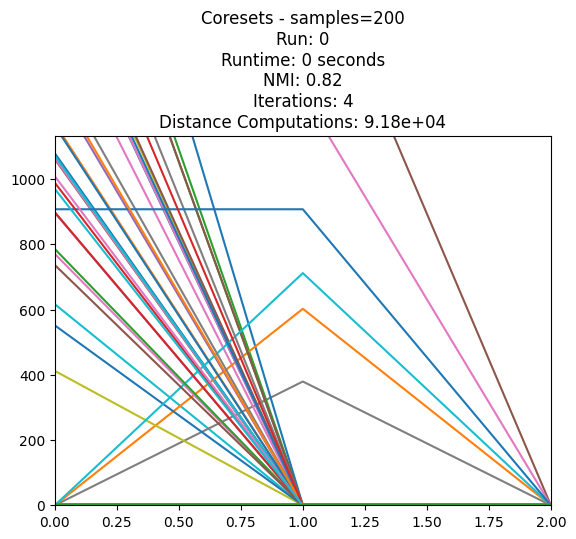

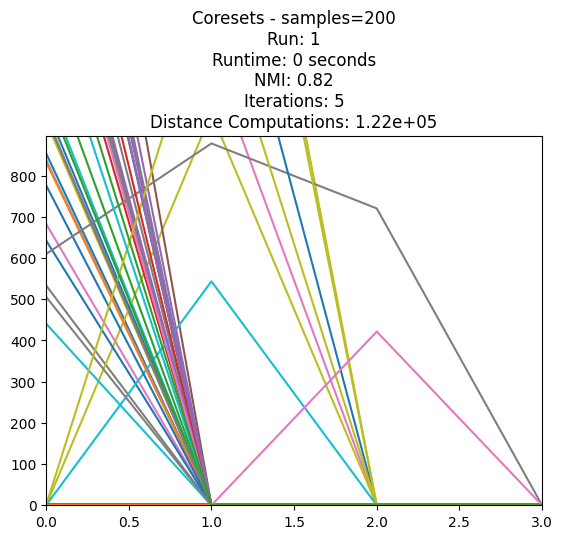

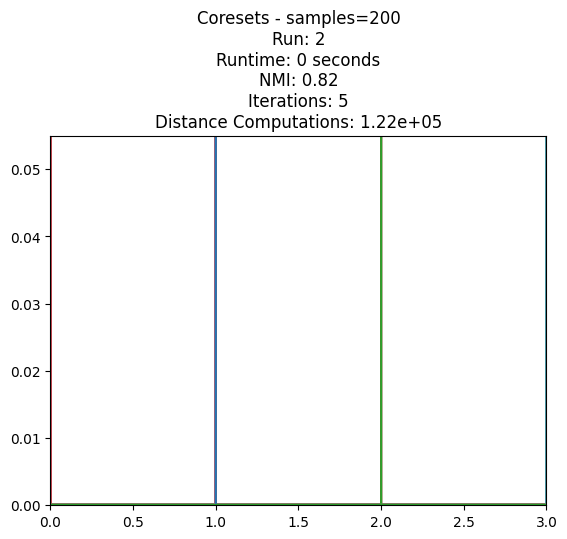

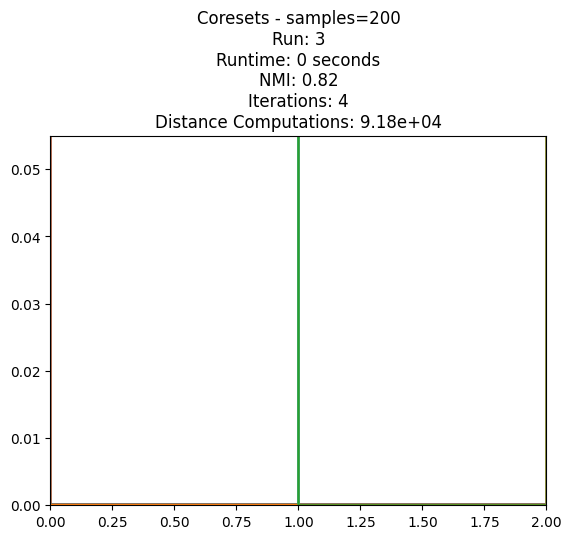

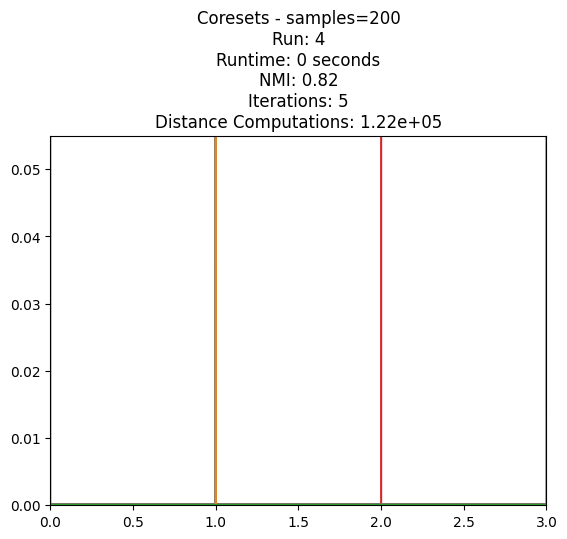

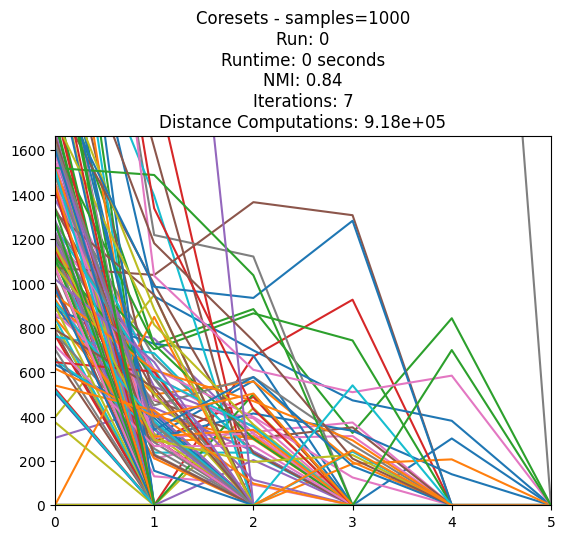

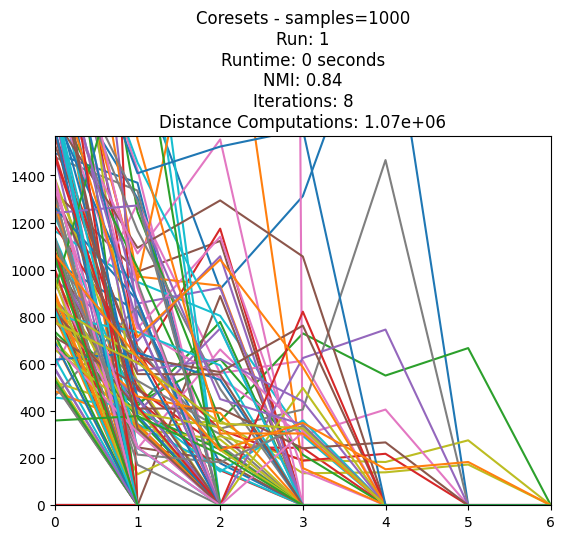

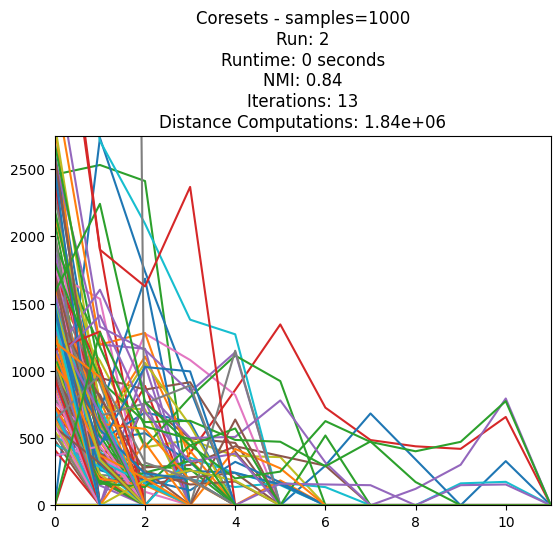

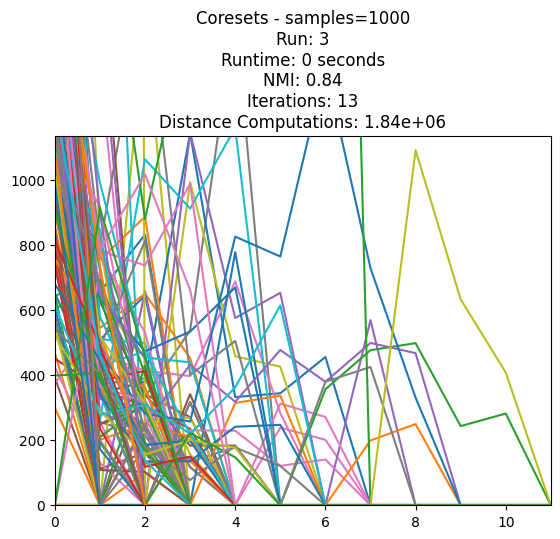

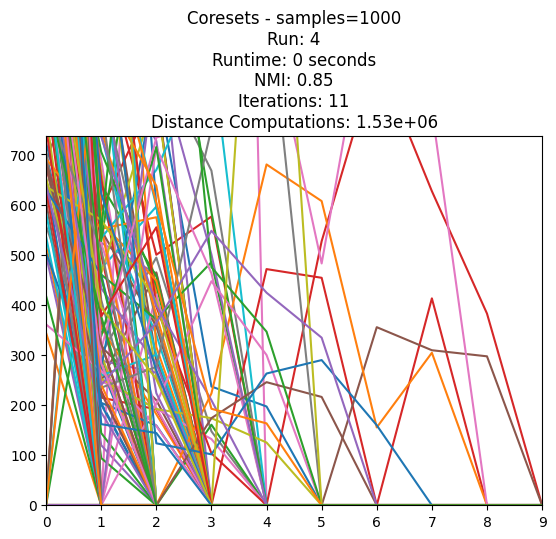

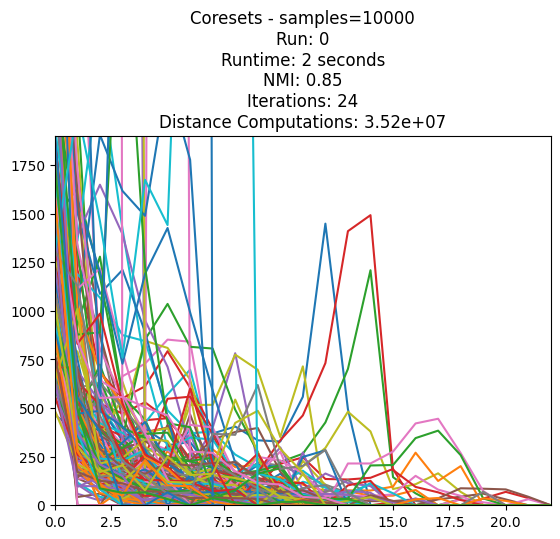

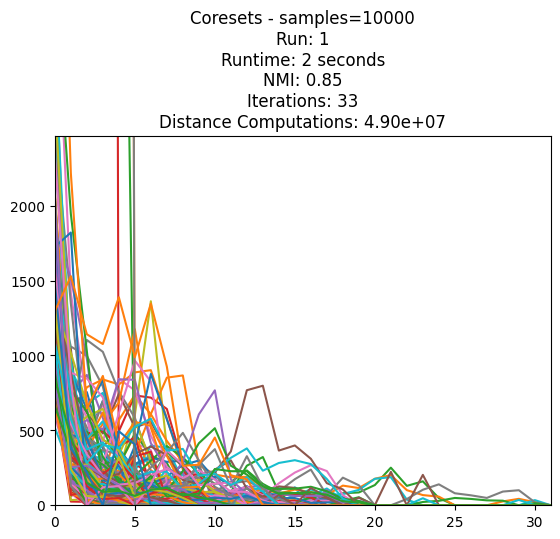

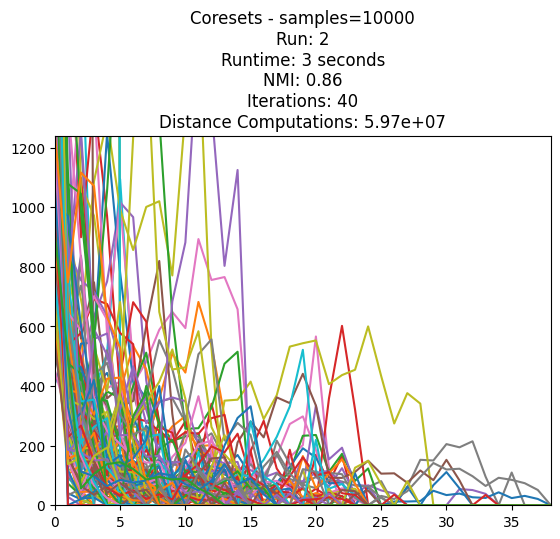

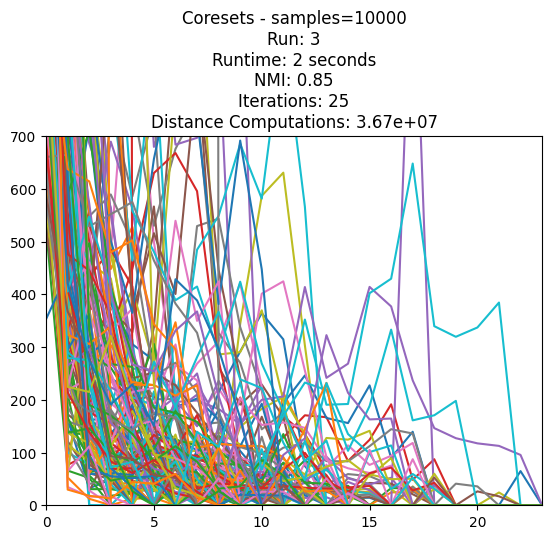

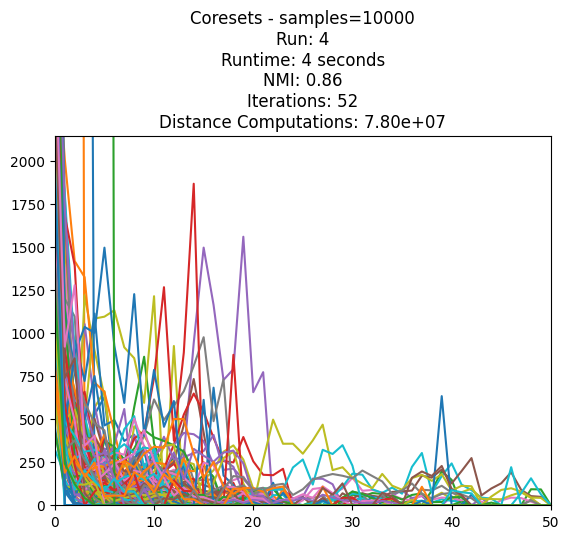

In [5]:
for samples in 200, 1_000, 10_000:
    coresets_title = f'Coresets - samples={samples}'
    report[coresets_title] = benchmark(
        X, y, k, runs, max_iter, atol, method='coresets', title=coresets_title,
        samples=samples
    )


In [ ]:
report_plot(report)
